K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [2]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_avg` LIMIT 5000
'''

df = client.query(sql).to_dataframe()

In [3]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [4]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [5]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns
0,8.639570,11.754115,50.683134,6.375049,1.908965e+04,1759.912492,55.608352,6.003069,2.062231e+04,1.830554e+03,...,15.334841,4.227678e+03,17.545042,4.782118e+03,2.653678e-02,2.683910e-01,3.325248e+05,3.291237e+05,342004.873606,3.422163e+05
1,28.709677,35.935484,8498.852198,337.449696,3.716790e+06,133327.937252,7344.354786,379.314658,3.099220e+06,1.655660e+05,...,827.994151,3.343440e+05,759.597368,3.042055e+05,3.476386e-15,3.947065e-12,1.001502e+06,1.604847e+06,668068.602371,1.370920e+06
2,19.666667,12.666667,23940.095369,1764.657422,1.463550e+07,758436.178875,24859.317667,3213.028092,1.396037e+07,1.458694e+06,...,3599.626555,1.585830e+06,3820.244607,1.591886e+06,1.765948e-14,1.633715e-11,1.768100e+05,4.143434e+05,716717.240513,1.729759e+06
3,25.713927,42.714932,127.796295,4.929312,5.725171e+04,2191.190438,140.756776,6.222590,6.085432e+04,2.562457e+03,...,11.467348,5.124107e+03,12.211096,5.435467e+03,9.451986e-02,3.467823e+01,9.274576e+05,1.300080e+06,766623.012868,1.258440e+06


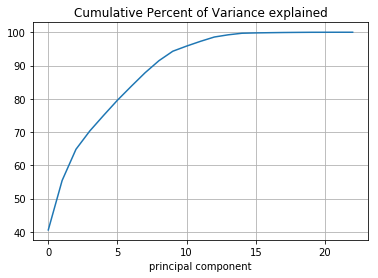

In [7]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

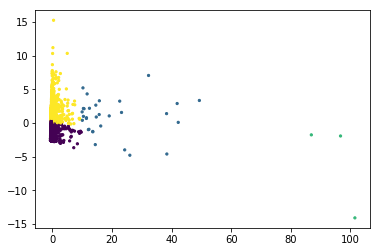

In [8]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_, s=5)

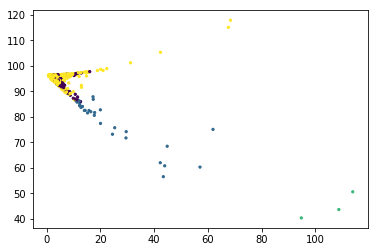

In [9]:
#plot in cluster distance space
r = cl.transform(results)
plt.scatter(r[:,3],r[:,2],c=cl.labels_, s=5)

In [10]:
#elbow method


In [11]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


Text(0.5,1,'Calinski Harabaz Scores')

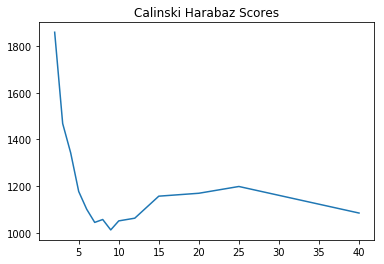

In [12]:
plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

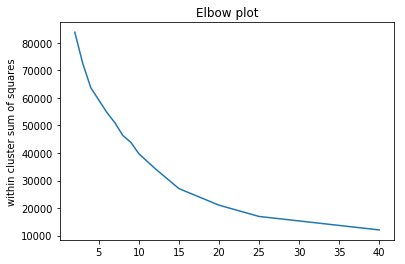

In [13]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [14]:
#optmal number of clusters is around 12
cl = KMeans(12)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
#outlier removal



def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [16]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

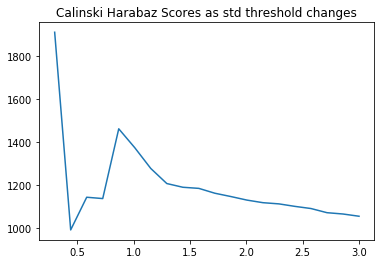

In [17]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [18]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.75)

(-15, 10)

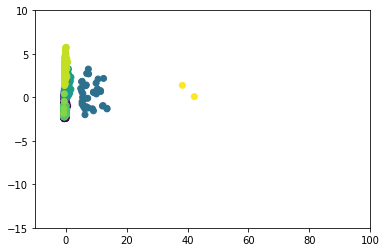

In [19]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)

(-15, 10)

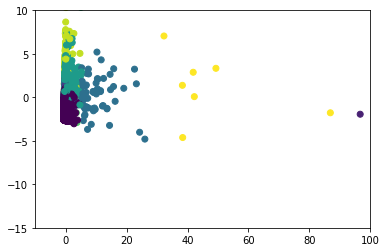

In [20]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
plt.xlim(-10,100)
plt.ylim(-15,10)

In [21]:
#recluster after changes
newcl = KMeans(12).fit(newresults)

In [22]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [23]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

In [24]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

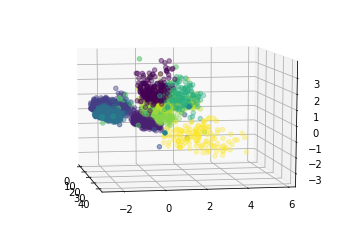

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

for ii in range(10,360,10):
    ax.view_init(elev=10, azim=ii)
    fig.savefig("movie/movie{}.png".format(ii))

In [26]:
c = newcl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns
0,33.230047,50.173709,36.630699,1.130569,2.291844e+04,695.227571,41.475594,0.931848,2.570062e+04,573.747022,...,3.244815,1994.691881,3.654803,2227.377691,4.694836e-03,1.737089e-01,4.733325e+05,4.141203e+05,600338.106496,5.967560e+05
1,8.337607,9.581197,28.619692,3.559633,7.437815e+03,887.020055,29.348678,3.230192,7.651283e+03,827.056254,...,7.436402,1854.044776,7.625000,1909.233266,2.983724e-16,-9.237056e-14,7.486564e+05,9.343795e+05,826848.882947,9.966621e+05
2,8.930649,10.035794,21.334057,2.619549,5.528629e+03,624.785442,22.637104,2.444691,5.912858e+03,595.132185,...,7.820134,1863.865518,8.285280,1985.038357,-2.775558e-17,-2.788880e-13,3.096044e+05,2.722096e+05,327369.276158,2.908133e+05
3,20.600000,40.000000,3468.622976,189.856644,1.872248e+06,94009.663236,3505.306854,169.688260,1.996683e+06,90724.218157,...,423.132533,212626.377176,428.276052,230174.127893,2.178813e-15,1.945111e-12,4.524004e+05,7.695281e+05,649295.873959,1.291395e+06
4,5.851324,6.678208,16.486584,2.657126,4.298199e+03,647.721505,17.519937,2.461893,4.581059e+03,610.635450,...,5.546719,1355.276506,5.924699,1450.531033,-1.457168e-16,7.460699e-14,2.204269e+05,2.322084e+05,237063.131908,2.419514e+05
5,36.000000,27.500000,16105.795068,519.224378,9.191782e+06,273033.323611,16106.453608,595.661644,9.599380e+06,346090.293858,...,1190.299172,656024.237582,1190.340405,681557.992395,1.321859e-14,6.952661e-12,6.877505e+05,1.606647e+06,823574.976411,1.297249e+06
6,20.500000,12.500000,7.235615,0.330150,3.616870e+03,155.251400,6.327381,0.493140,2.849202e+03,173.360665,...,0.790272,391.921402,0.700639,288.739652,1.366667e+01,6.783333e+01,6.514272e+05,9.846115e+05,273518.053458,5.431185e+05
7,40.425532,39.510638,121.260374,3.035966,6.736907e+04,1695.761466,131.562174,3.577595,7.234232e+04,1994.337917,...,8.252828,4618.028913,8.908963,4945.458705,4.718448e-16,1.367795e-13,7.335018e+05,1.283824e+06,677083.459684,1.245882e+06
8,23.666667,41.333333,2242.230802,112.624315,1.124455e+06,49784.818025,2338.126341,98.799991,1.218138e+06,48806.565409,...,253.161562,112877.828879,262.160393,121948.349317,1.526557e-15,1.135092e-12,3.973978e+05,8.205240e+05,540060.545907,8.466240e+05
9,17.108434,20.915663,40.362506,2.491846,1.785596e+04,1091.410700,42.271147,2.202507,1.894416e+04,986.129761,...,5.340914,2327.229041,5.591128,2469.161650,2.844947e-16,7.815970e-14,7.740580e+05,9.675231e+05,877577.325693,1.091343e+06
